# Viterbi Decoding

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

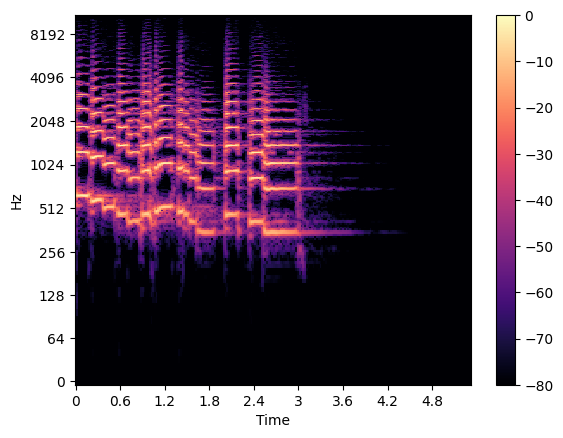

In [3]:
y, sr = librosa.load(librosa.ex('trumpet'))

S_full, phase = librosa.magphase(librosa.stft(y))

fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(S_full, ref = np.max), y_axis = 'log', x_axis = 'time', sr = sr, ax = ax)

fig.colorbar(img, ax = ax)

[Text(0.5, 0, 'Time'), Text(0, 0.5, 'RMS')]

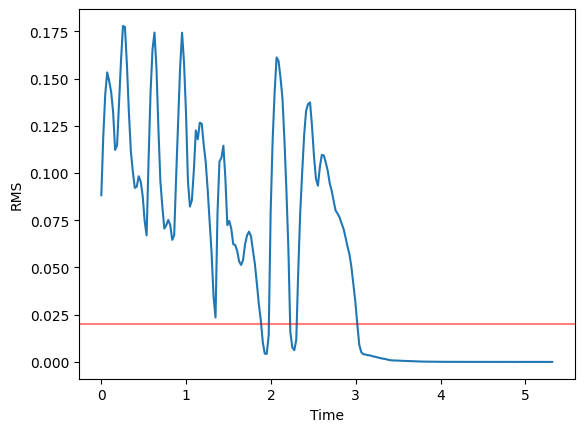

In [4]:
rms = librosa.feature.rms(y = y)[0]

times = librosa.frames_to_time(np.arange(len(rms)))

fig, ax = plt.subplots()
ax.plot(times, rms)
ax.axhline(0.02, color = 'r', alpha = 0.5)
ax.set(xlabel = 'Time', ylabel = 'RMS')

The red line indicates a reasonable threshold for silence detection, but the RMS curve occasionally dips below this momentarily; Viterbi algo helps here

Convert raw RMS val into a probability by logistic mapping

![Screenshot from 2024-05-21 16-49-59.png](<attachment:Screenshot from 2024-05-21 16-49-59.png>)

x is RMS value and r represnts the threshold; V represents whether the signal is non-silent(1) or silent(0)
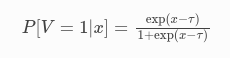

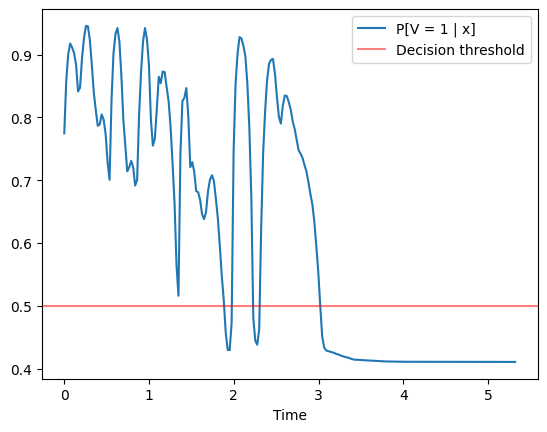

In [5]:
# normalizing the RMS its standard deviation to expand the range of the probability vector

r_normalized = (rms - 0.02) / np.std(rms)
p = np.exp(r_normalized) / (1 + np.exp(r_normalized))

fig, ax = plt.subplots()
ax.plot(times, p, label = 'P[V = 1 | x]')
ax.axhline(0.5, color = 'r', alpha = 0.5, label = 'Decision threshold')
ax.set(xlabel = 'Time')
ax.legend()

# threshold shifted to 0.5

<Figure size 1200x600 with 0 Axes>

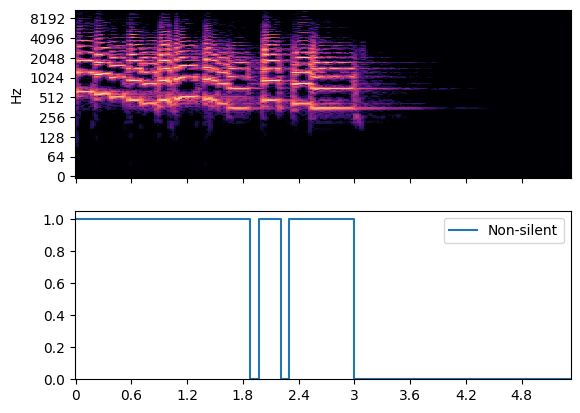

In [6]:
# simple silence detector that classified each frame independently of its neighbours

plt.figure(figsize = (12, 6))
fig, ax = plt.subplots(nrows = 2, sharex = True)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref = np.max), y_axis = 'log', x_axis = 'time', sr = sr, ax = ax[0])

ax[0].label_outer()
ax[1].step(times, p >= 0.5, label = 'Non-silent')
ax[1].set(ylim = [0, 1.05])
ax[1].legend()

better algorithm
- 0 - silent; 1 - non-silent
- silent frame is equally likely to be foollowed by silence or non-silenec
- non-silent frame is slightly more likely to be followed by non-silence
- self-loop transition matrix; transition[i, j] represents prob of moving from state i to state j in next frame

In [8]:
transition = librosa.sequence.transition_loop(2, [0.5, 0.6])
print(transition)

full_p = np.vstack([1 - p, p])
print(full_p)

[[0.5 0.5]
 [0.4 0.6]]
[[0.22557992 0.14172435 0.0995599  0.08246648 0.08900827 0.09782773
  0.11637747 0.15879065 0.15290713 0.10642171 0.07418841 0.05446672
  0.05499524 0.07721573 0.11640877 0.160384   0.1885227  0.21342498
  0.21139461 0.19533944 0.2037422  0.22636586 0.27143532 0.29951745
  0.17240483 0.09821188 0.06726509 0.05782139 0.07934618 0.13382572
  0.20342726 0.24540085 0.28605753 0.27937305 0.26941776 0.2792554
  0.30859733 0.29949445 0.19619685 0.12755245 0.07941294 0.05790144
  0.07562256 0.11657298 0.20322877 0.24504036 0.23386127 0.18626863
  0.13534808 0.14560008 0.12699729 0.12807924 0.15231955 0.17440838
  0.2158109  0.27354234 0.33623517 0.43460763 0.48399287 0.25713342
  0.17415017 0.16882974 0.15344495 0.19861054 0.27945882 0.27131325
  0.28638357 0.31745416 0.31924272 0.3316443  0.35461712 0.36199337
  0.35072583 0.31771964 0.29938602 0.29216415 0.30131018 0.32971174
  0.36052036 0.4044851  0.45268172 0.4909054  0.54291505 0.570173
  0.570663   0.5268914  0.25

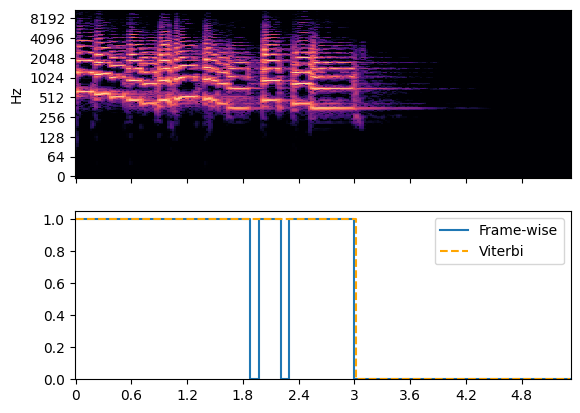

In [10]:
states = librosa.sequence.viterbi_discriminative(full_p, transition)

fig, ax = plt.subplots(nrows = 2, sharex = True)
librosa.display.specshow(librosa.amplitude_to_db(S_full, ref = np.max),
                         y_axis = 'log', x_axis = 'time', sr = sr, ax = ax[0])
ax[0].label_outer()
ax[1].step(times, p >= 0.5, label = 'Frame-wise')
ax[1].step(times, states, linestyle = '--', color = 'orange', label = 'Viterbi')
ax[1].set(ylim = [0, 1.05])
ax[1].legend()